# 线性神经网络

## 线性回归

$ x^2 $

### 正态分布

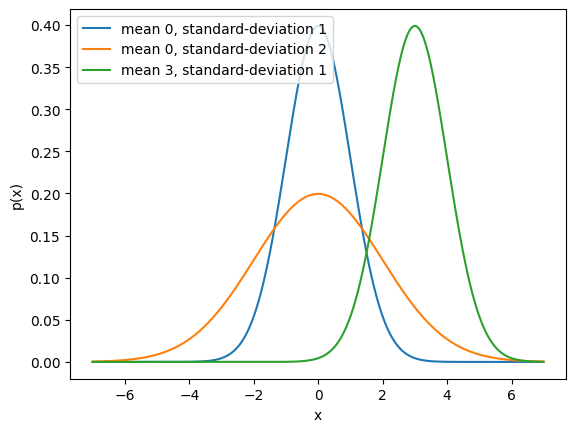

In [43]:
import math

import matplotlib.pyplot as plt
import numpy as np


def normal_distribution(_x, _mu, _sigma):
    p = 1 / math.sqrt(2 * math.pi * _sigma ** 2)
    return p * np.exp(-0.5 / _sigma ** 2 * (_x - _mu) ** 2)


x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]

for mu, sigma in params:
    plt.plot(x, normal_distribution(x, mu, sigma), label=f'mean {mu}, standard-deviation {sigma}')

plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()

plt.show()

### 人造数据集

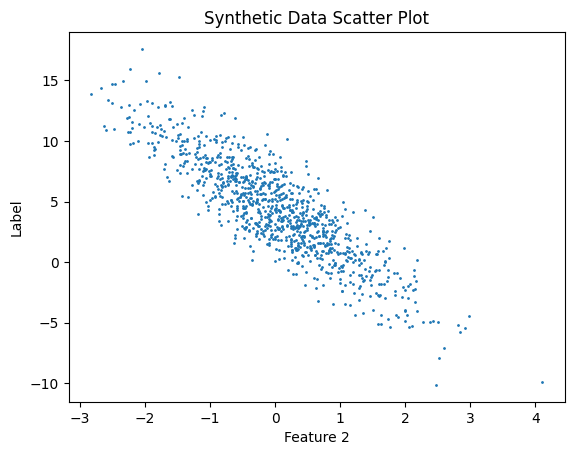

In [44]:
import torch
import matplotlib.pyplot as plt


# ⽣成y=Xw+b+噪声的合成数据函数
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成均值为0，标准差为1的正态分布随机特征数据
    y = torch.matmul(X, w) + b  # 计算标签y，y=Xw+b
    y += torch.normal(0, 0.01, y.shape)  # 添加均值为0，标准差为0.01的噪声
    return X, y.reshape((-1, 1))  # 返回特征数据X和标签数据y，将y reshape为列向量


true_w = torch.tensor([2, -3.4])  # 真实的权重向量w
true_b = 4.2  # 真实的偏置b
features, labels = synthetic_data(true_w, true_b, 1000)  # 生成1000个样本的合成数据

# 绘制特征(features)的第二列和对应标签(labels)的散点图
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
# x轴标签
plt.xlabel('Feature 2')
# y轴标签
plt.ylabel('Label')
plt.title('Synthetic Data Scatter Plot')
# 显示散点图
plt.show()


In [52]:
import random
import torch


def data_iter(batch_size, features, labels):
    """生成随机顺序的小批量样本"""
    num_examples = len(features)  # 获取样本数量
    indices = list(range(num_examples))  # 创建样本索引列表
    random.shuffle(indices)  # 将样本索引列表随机打乱，用于随机读取样本

    # 生成每个batch的样本集合
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])  # 获取当前batch的样本索引
        yield features[batch_indices], labels[batch_indices]  # 返回当前batch的特征和标签


w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b


def squared_loss(y_hat, y):
    """均⽅损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


def sgd(params, lr, batch_size):
    """⼩批量随机梯度下降
    :param params: 要更新的参数列表
    :param lr: 学习率
    :param batch_size: 批量大小
    """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
    param.grad.zero_()


# 设置超参数
lr = 0.03
num_epochs = 20
net = linreg
loss = squared_loss
batch_size = 90

# 外部循环遍历每个epoch
for epoch in range(num_epochs):
    # 内部循环遍历数据的每个batch
    for X, y in data_iter(batch_size, features, labels):
        # 计算当前batch的损失
        l = loss(net(X, w, b), y)
        # 求损失函数关于[w, b]的梯度
        l.sum().backward()
        # 使用随机梯度下降（SGD）更新参数[w, b]
        sgd([w, b], lr, batch_size)

    # 完成一个epoch后，计算整体的训练损失
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


epoch 1, loss 8.093689
epoch 2, loss 3.732718
epoch 3, loss 9.772672
epoch 4, loss 3.559274
epoch 5, loss 1.979332
epoch 6, loss 8.336006
epoch 7, loss 2.052288
epoch 8, loss 2.815929
epoch 9, loss 8.496810
epoch 10, loss 1.777567
epoch 11, loss 3.286985
epoch 12, loss 9.361797
epoch 13, loss 1.578514
epoch 14, loss 3.316516
epoch 15, loss 7.837400
epoch 16, loss 1.142763
epoch 17, loss 3.671350
epoch 18, loss 6.090602
epoch 19, loss 0.508215
epoch 20, loss 4.276978


### 使用框架

In [54]:
import numpy as np
import torch
from torch.utils import data
from torch import nn

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造⼀个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


batch_size = 10
data_iter = load_array((features, labels), batch_size)

net = nn.Sequential(nn.Linear(2, 1))

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()

trainer = torch.optim.SGD(net.parameters(), lr=0.03)

num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000555
epoch 2, loss 0.000104
epoch 3, loss 0.000106
